In [1]:
import SimpleITK as sitk
import os
from multiprocessing import pool
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
#from skimage.transform import resize

In [185]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")

In [186]:
image_001_frame01 = nib.load("patient001_frame01.nii.gz")

In [187]:
image_001_frame01.shape

(216, 256, 10)

In [188]:
array_frame001 = image_001_frame01.get_fdata()

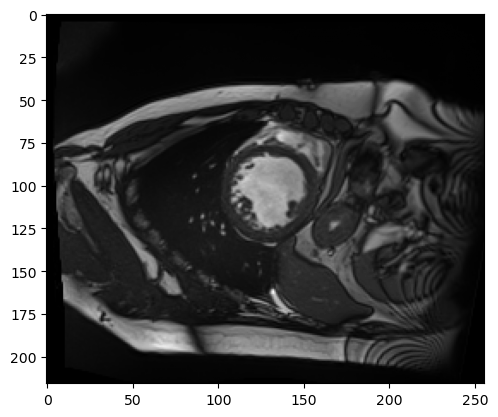

In [189]:
plt.imshow(array_frame001[:,:,5],cmap ="gray")

In [190]:
image_001_frame12 = nib.load("patient001_frame01.nii.gz")

In [191]:
np.array(image_001_frame12.header.get_zooms())[[2,1,0]]

array([10.    ,  1.5625,  1.5625], dtype=float32)

In [192]:
image_001_frame12.shape

(216, 256, 10)

In [193]:
image_001 = sitk.ReadImage("patient001_4d.nii.gz")

In [194]:
array_image001 = sitk.GetArrayFromImage(image_001)

In [195]:
array_image001.shape

(30, 10, 256, 216)

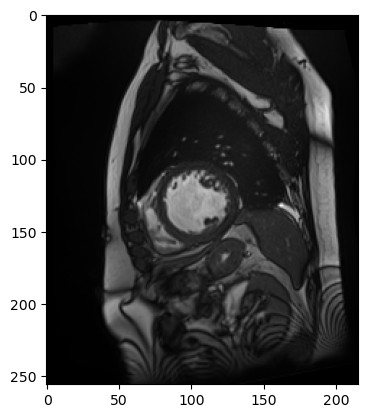

In [196]:
plt.imshow(array_image001[2,5,:,:],cmap ="gray")

In [77]:
np.array(image_001.GetSpacing())

array([ 1.5625,  1.5625, 10.    ,  1.    ])

In [73]:
image_001nib = nib.load("patient001_4d.nii.gz")

In [78]:
np.array(image_001nib.header.get_zooms())

array([ 1.5625,  1.5625, 10.    ,  1.    ], dtype=float32)

In [216]:
def resize_image(image, old_spacing, new_spacing, order=3):
    new_shape = (int(np.round(old_spacing[0]/new_spacing[0]*float(image.shape[0]))),
                 int(np.round(old_spacing[1]/new_spacing[1]*float(image.shape[1]))),
                 int(np.round(old_spacing[2]/new_spacing[2]*float(image.shape[2]))))
    return resize(image, new_shape, order=order, mode='edge')

def convert_to_one_hot(seg):
    vals = np.unique(seg)
    res = np.zeros([len(vals)] + list(seg.shape), seg.dtype)
    for c in range(len(vals)):
        res[c][seg == c] = 1
    return res


def preprocess_image(nib_image, spacing_target, is_seg=False, keep_z_spacing=False):
    spacing = np.array(nib_image.header.get_zooms())[[2, 1, 0]]
    image = nib_image.get_fdata()
    if keep_z_spacing:
        spacing_target = list(spacing_target)
        spacing_target[0] = spacing[0]
    if not is_seg:
        order_img = 3
        if not keep_z_spacing:
            order_img = 1
        image = resize_image(image, spacing, spacing_target, order=order_img).astype(np.float32)
        image -= image.mean()
        image /= image.std()
    else:
        tmp = convert_to_one_hot(image)
        vals = np.unique(image)
        results = []
        for i in range(len(tmp)):
            results.append(resize_image(tmp[i].astype(float), spacing, spacing_target, 1)[None])
        image = vals[np.vstack(results).argmax(0)]
    return image

str_to_ind = {'DCM':0, 'HCM':1, 'MINF':2, 'NOR':3, 'RV':4}
ind_to_str = {}
for k in str_to_ind.keys():
    ind_to_str[str_to_ind[k]] = k

def process_patient(idx, patient_info, folder, folder_out, keep_z_spc):
    #print id
    # if id in [286, 288]:
    #     return
    patient_folder = os.path.join(folder, "patient%03.0d"%idx)
    if not os.path.isdir(patient_folder):
        return
    images = {}

    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (idx, patient_info[idx]['ED']))
    if os.path.isfile(fname):
        images["ed"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (idx, patient_info[idx]['ED']))
    if os.path.isfile(fname):
        images["ed_seg"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (idx, patient_info[idx]['ES']))
    if os.path.isfile(fname):
        images["es"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (idx, patient_info[idx]['ES']))
    if os.path.isfile(fname):
        images["es_seg"] = nib.load(fname)


    for k in images.keys():
        #print k
        images[k] = preprocess_image(images[k],spacing_target=(10, 1.25, 1.25), is_seg=(k == "ed_seg" or k == "es_seg"),keep_z_spacing=keep_z_spc)

    img_as_list = []
    for k in ['ed', 'ed_seg', 'es', 'es_seg']:
        if k not in images.keys():
            print(f"{idx} has missing key {k}")
        img_as_list.append(images[k][None])
    # Save all images of a patient in a stack of numpy in a folder
    try:
        all_img = np.vstack(img_as_list)
    except:
        print(f"{idx} has a problem with spacings")
    np.save(os.path.join(folder_out, "pat_%03.0d" %idx), all_img.astype(np.float32))
    
def generate_patient_info(folder,idx_start,idx_stop):
    patient_info={}
    for idx in range(idx_start,idx_stop+1):
        fldr = os.path.join(folder, 'patient%03.0d'%idx)
        print(fldr)
        if not os.path.isdir(fldr):
            print (f"could not find dir of patient {idx}")
            continue
        nfo = np.loadtxt(os.path.join(fldr, "Info.cfg"), dtype=str)
        print(patient_info)
        patient_info[idx] = {}
        patient_info[idx]['ed'] = int(nfo[0, 1])
        patient_info[idx]['es'] = int(nfo[1, 1])
        patient_info[idx]['height'] = float(nfo[3, 1])
        patient_info[idx]['pathology'] = nfo[2, 1]
        patient_info[idx]['weight'] = float(nfo[5, 1])
    return patient_info

# Did not test this yet
# To run the data preprocessing simultaneouly for big dataset
def run_preprocessing(folder_in,folder_out, idx_start,idx_stop, keep_z_spacing=True):
    patient_info = generate_patient_info(folder_in)

    if not os.path.isdir(folder_out):
        os.mkdir(folder_out)
    with open(os.path.join(folder_out, "patient_info.pkl"), 'w') as f:
        pickle.dump(patient_info, f)

    # beware of z spacing!!! see process_patient for more info!
    ids = range(idx_start,idx_stop+1)
    p = pool.Pool(8)
    p.map(process_patient, zip(ids, [patient_info]*len(ids), [folder]*len(ids), [folder_out]*len(ids), [keep_z_spacing]*len(ids)))
    p.close()
    p.join()


In [170]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
after = preprocess_image(patient_001,spacing_target=(10, 1.25, 1.25),keep_z_spacing=False)

In [171]:
after.shape

(216, 320, 12)

In [172]:
patient_001.shape

(216, 256, 10)

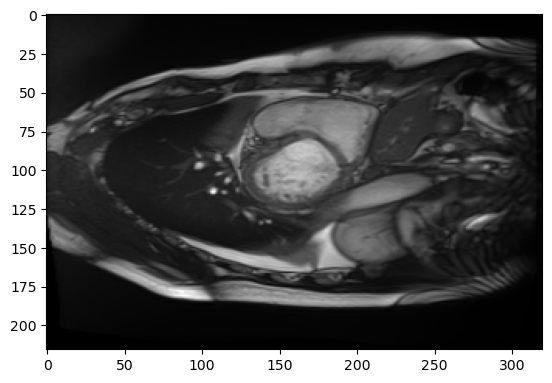

In [181]:
plt.imshow(after[:,:,1],cmap ="gray")

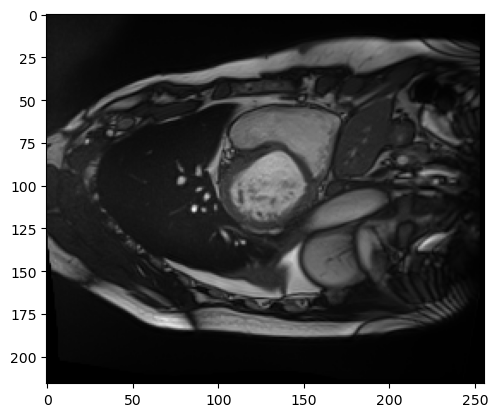

In [182]:
plt.imshow(patient_001.get_fdata()[:,:,1],cmap ="gray")

In [183]:
patient_001_gt = nib.load("patient001_frame01_gt.nii.gz")
after_gt = preprocess_image(patient_001_gt,spacing_target=(10, 1.25, 1.25),keep_z_spacing=False)

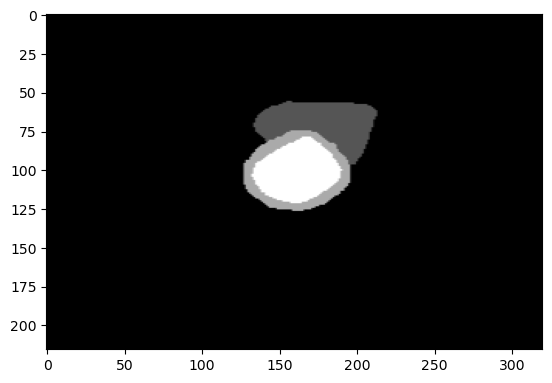

In [184]:
plt.imshow(after_gt[:,:,1],cmap ="gray")

In [217]:
patient_info = generate_patient_info("/Users/Thanh/master/Visualization_lab/SAM/database/training",1,5)

/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001
{}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient002
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient003
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0}}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient004
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0}, 3: {'ed': 1, 'es': 15, 'height': 165.0, 'pathology': 'DCM', 'weight': 77.0}}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient005
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0}, 3: {'ed': 1, 'es': 15,

In [203]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")

In [206]:
nfo = np.loadtxt("Info.cfg", dtype=str)

In [208]:
nfo[0,1]

'1'

In [218]:
patient_info

{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0},
 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0},
 3: {'ed': 1, 'es': 15, 'height': 165.0, 'pathology': 'DCM', 'weight': 77.0},
 4: {'ed': 1, 'es': 15, 'height': 159.0, 'pathology': 'DCM', 'weight': 46.0},
 5: {'ed': 1, 'es': 13, 'height': 165.0, 'pathology': 'DCM', 'weight': 77.0}}